# Feedback Effectiveness Prize PyTorch TPU starter - DeBERTa-v3-large (training)
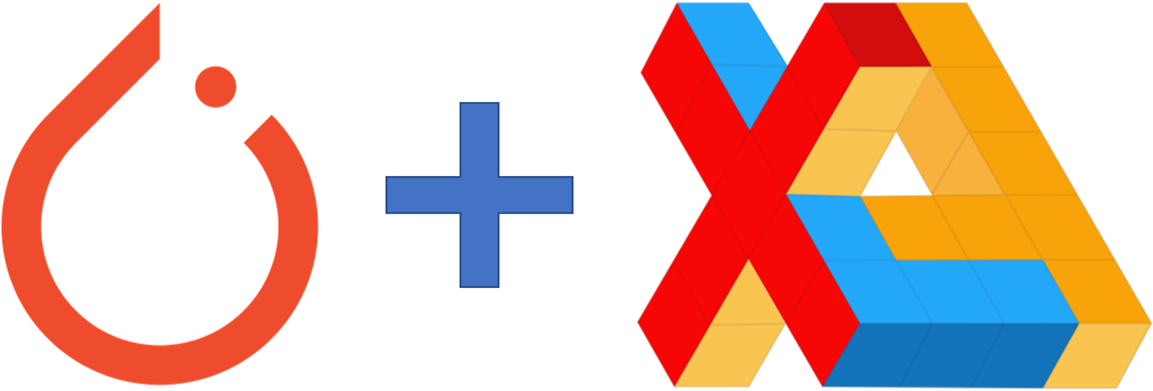

#### If you found this helpful, please give it an upvote!

# Introduction
PyTorch XLA is a PyTorch library for XLA support. XLA (Accelerated Linear Algebra) is a domain-specific compiler that was originally meant for compiling and accelerating TensorFlow models. However, other packages, like JAX and now PyTorch XLA can compile program with XLA to accelerate code. TPUs can be programmed with XLA programs and PyTorch XLA provides this interface with TPUs by compiling our PyTorch code as XLA programs to run on TPU devices.

In this kernel, I provide an in-depth look into how you can use PyTorch XLA to train a PyTorch model on the TPU for the Feedback Effectiveness Prize competition.


# Installs & Imports

The below cell will install the PyTorch XLA package. We will use version 1.11 of the package:

In [ ]:
VERSION = "1.11"
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py > /dev/null
!python pytorch-xla-env-setup.py --version $VERSION  > /dev/null

We need to upgrade some packages too:

In [ ]:
!pip install --upgrade transformers
!pip install datasets
!pip install --upgrade huggingface_hub

Here are all of our imports!

In [ ]:
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import warnings,transformers,logging,torch
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification,AutoTokenizer
from transformers import AdamW, get_cosine_schedule_with_warmup
import datasets
from datasets import load_dataset, Dataset, DatasetDict
from sklearn.metrics import log_loss
from pathlib import Path
import torch.nn.functional as F
import os
import gc


# PyTorch XLA-specific imports
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.debug.metrics as met

In [ ]:
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

Now let's define the necessary functions and variables needed for training.

These are some hyperparameters for training. When you fork (after you upvote of course, ;) ), feel free to play around with these hyperparameters!

In [ ]:
BATCH_SIZE=16
EPOCHS=1
NUM_WORKERS=8
OPTIM = AdamW
LR=1e-5
WD = 0.01
WARMUP_PCT=0.1

## Dataset creation

The best approach to speed up dataloading is to create the preprocessed dataset, and even better to save RAM resources is if it's memory-mapped. We can do both with HuggingFace Datasets. I have taken the code from my previous notebook [here](https://www.kaggle.com/code/tanlikesmath/feedback-prize-effectiveness-eda-deberta-baseline).

In [ ]:
path = Path('../input/feedback-prize-effectiveness')

In [ ]:
df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')


In [ ]:
tokz = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large', model_max_length=512)
sep = tokz.sep_token
df['inputs'] = df.discourse_type + sep +df.discourse_text
new_label = {"discourse_effectiveness": {"Ineffective": 0, "Adequate": 1, "Effective": 2}}
df = df.replace(new_label)
df = df.rename(columns = {"discourse_effectiveness": "labels"})

In [ ]:
def tok_func(x): return tokz(x["inputs"], padding='max_length', truncation=True)

In [ ]:
essay_ids = df.essay_id.unique()
np.random.seed(42)
np.random.shuffle(essay_ids)
essay_ids[:5]
val_prop = 0.2
val_sz = int(len(essay_ids)*val_prop)
val_essay_ids = essay_ids[:val_sz]
is_val = np.isin(df.essay_id, val_essay_ids)
idxs = np.arange(len(df))
val_idxs = idxs[ is_val]
trn_idxs = idxs[~is_val]
len(val_idxs),len(trn_idxs)

In [ ]:
def get_dds(df, train=True):
    ds = Dataset.from_pandas(df)
    to_remove = ['discourse_text','discourse_type','inputs','discourse_id','essay_id']
    tok_ds = ds.map(tok_func, batched=True, remove_columns=to_remove)
    if train:
        return DatasetDict({"train":tok_ds.select(trn_idxs), "test": tok_ds.select(val_idxs)})
    else: 
        return tok_ds

We'll now same the dataset to the disk, and we can load again later when we start our training.

In [ ]:
dds = get_dds(df)
dds.save_to_disk('dds')

# Training code

Let's start training! To do so, we start by initializing the model. We use the `xmp.MpModelWrapper` provided by PyTorch XLA to save memory when initializing the model.

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('microsoft/deberta-v3-large', num_labels=3)
mx = xmp.MpModelWrapper(model)

Let's now define our training and validation functions.

In [ ]:
def train_loop_fn(data_loader, loss_fn, model, optimizer, device, scheduler=None):
    model.train() # put model in training mode
    for bi, d in enumerate(data_loader): # enumerate through the dataloader
        
        # put tensors onto desired device, in this case the TPU core
        for k,v in d.items():
            d[k] = v.to(device)

        # pass ids to model
        optimizer.zero_grad()
        outputs = model(**d)
        # calculate loss
        loss = loss_fn(outputs['logits'], d['labels'])
        if bi % 50 == 0:
            # since the loss is on all 8 cores, reduce the loss values and print the average
            loss_reduced = xm.mesh_reduce('loss_reduce',loss, lambda x: sum(x) / len(x)) 
            # master_print will only print once (not from all 8 cores)
            xm.master_print(f'bi={bi}, loss={loss_reduced}')
            
        # backpropagate
        loss.backward()
        
        # Use PyTorch XLA optimizer stepping
        xm.optimizer_step(optimizer)
        if scheduler is not None:
            scheduler.step()
        
    model.eval() # put model in eval mode for later use
    
def eval_loop_fn(data_loader, loss_fn, model, device):
    fin_targets = []
    fin_outputs = []
    for bi, d in enumerate(data_loader): # enumerate through dataloader

        # put tensors onto desired device, in this case the TPU core
        for k,v in d.items():
            d[k] = v.to(device)
            
        # pass ids to model
        with torch.no_grad(): outputs = model(**d)

        # Add the outputs and targets to a list 
        targets = d['labels'].cpu().detach().tolist()
        outputs = outputs['logits'].cpu().detach().tolist()
        fin_targets.extend(targets)
        fin_outputs.extend(outputs)    
        del targets, outputs
        gc.collect() # delete for memory conservation
            
    # calculate loss
    loss = loss_fn(torch.tensor(fin_outputs), torch.tensor(fin_targets))
    # since the loss is on all 8 cores, reduce the loss values and print the average
    loss_reduced = xm.mesh_reduce('loss_reduce',loss, lambda x: sum(x) / len(x)) 
    # master_print will only print once (not from all 8 cores)
    xm.master_print(f'val. loss={loss_reduced}')


Finally, we define a main function that we will run on each of the 8 cores of the TPU.

In [ ]:
def main(mx):
    dds = datasets.load_from_disk('dds') # load dataset from disk
    dds.set_format('torch') # set the dataset to return torch Tensors
    
    train_dataset = dds['train']
    # defining data samplers and loaders 
    train_sampler = torch.utils.data.distributed.DistributedSampler(
          train_dataset,
          num_replicas=xm.xrt_world_size(), # tell PyTorch how many devices (TPU cores) we are using for training
          rank=xm.get_ordinal(), # tell PyTorch which device (core) we are on currently
          shuffle=True)
    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_sampler,
        drop_last=True,
        num_workers=NUM_WORKERS
    )
    
    valid_dataset = dds['test']
    valid_sampler = torch.utils.data.distributed.DistributedSampler(
          valid_dataset,
          num_replicas=xm.xrt_world_size(),
          rank=xm.get_ordinal(),
          shuffle=False)

    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        sampler=valid_sampler,
        drop_last=False,
        num_workers=NUM_WORKERS
    )
    
    device = xm.xla_device() # our device (single TPU core)
    
    # PyTorch XLA-specific dataloading
    train_loader = pl.MpDeviceLoader(train_data_loader, device) 
    valid_loader = pl.MpDeviceLoader(valid_data_loader, device)
    
    model = mx.to(device) # put model onto the current TPU core
    xm.master_print('done loading model and dataloader')
    
    
    param_optimizer = list(model.named_parameters()) # model parameters to optimize
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    # apply to weight decay
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': WD},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]

    xm.master_print('training on train dataset')
    
    lr = LR * xm.xrt_world_size() # scale the learning rate
    # calculate the total number of training steps
    num_train_steps = int(len(train_dataset) / BATCH_SIZE / xm.xrt_world_size() * EPOCHS) 
    
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = OPTIM(optimizer_grouped_parameters, lr=lr) # define our optimizer
    
    # a scheduler can be used if desired
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(num_train_steps*WARMUP_PCT),
        num_training_steps=num_train_steps
    )
    xm.master_print(f'num_training_steps = {num_train_steps}, world_size={xm.xrt_world_size()}')
    
    # Let's start training on the train set!
    for epoch in range(EPOCHS):
        gc.collect() # I use a lot of gc.collect() statement to hopefully prevent OOM problems
        # call training loop:
        train_loop_fn(train_loader, loss_fn, model, optimizer, device, scheduler=scheduler)
        gc.collect()
        # call evaluation loop:
        eval_loop_fn(valid_loader, loss_fn, model, device)
        gc.collect()
        
    xm.rendezvous('save_model')
    xm.master_print('save model')
    xm.save(model.state_dict(), f'xla_trained_model_epoch_{epoch}.pth')

In [ ]:
def _mp_fn(index):
    # For xla_spawn (TPUs)
    device = xm.xla_device()
    # We wrap this 
    main(mx)

We need to set some environment variables before training, such as using faster bfloat16 training, dealing with HuggingFace tokenizer parallelism warning, etc.

In [ ]:
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
os.environ['XLA_USE_BF16']="1"
os.environ['XLA_TENSOR_ALLOCATOR_MAXSIZE'] = '100000000'
os.environ['XLA_EXPERIMENTAL'] = 'nonzero:masked_select'

Let's start training!

In [ ]:
xmp.spawn(_mp_fn, args=(), nprocs=8, start_method='fork')

Now, **WE ARE DONE!**

If you enjoyed this kernel, please give it an upvote. If you have any questions or suggestions, please leave a comment!